# Set up environment

In [ ]:
!pip install torchtext==0.10.0

In [267]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd

from sklearn.preprocessing import LabelEncoder
import torchtext 

print(torchtext.__version__)
# from torchtext.data import *
from torchtext.legacy import *
from torchtext.legacy.data import *
import nltk
nltk.download('punkt')
from nltk import word_tokenize

0.10.0


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Load dataset

In [270]:
train_df = pd.read_csv("train_sent_emo.csv")
test_df = pd.read_csv("test_sent_emo.csv")
train_df

,Sr No.,Utterance,Speaker,Emotion,Sentiment,Dialogue_ID,Utterance_ID,Season,Episode,StartTime,EndTime
0,1,also I was the point person on my companys tr...,Chandler,neutral,neutral,0,0,8,21,"00:16:16,059","00:16:21,731"
1,2,You mustve had your hands full.,The Interviewer,neutral,neutral,0,1,8,21,"00:16:21,940","00:16:23,442"
2,3,That I did. That I did.,Chandler,neutral,neutral,0,2,8,21,"00:16:23,442","00:16:26,389"
3,4,So lets talk a little bit about your duties.,The Interviewer,neutral,neutral,0,3,8,21,"00:16:26,820","00:16:29,572"
4,5,My duties? All right.,Chandler,surprise,positive,0,4,8,21,"00:16:34,452","00:16:40,917"
...,...,...,...,...,...,...,...,...,...,...,...
9984,10474,You or me?,Chandler,neutral,neutral,1038,13,2,3,"00:00:48,173","00:00:50,799"
9985,10475,"I got it. Uh, Joey, women don't have Adam's ap...",Ross,neutral,neutral,1038,14,2,3,"00:00:51,009","00:00:53,594"
9986,10476,"You guys are messing with me, right?",Joey,surprise,positive,1038,15,2,3,"00:01:00,518","00:01:03,520"
9987,10477,Yeah.,All,neutral,neutral,1038,16,2,3,"00:01:05,398","00:01:07,274"


# Preprocessing

In [271]:
train_df.Emotion.value_counts()

neutral     4710
joy         1743
surprise    1205
anger       1109
sadness      683
disgust      271
fear         268
Name: Emotion, dtype: int64

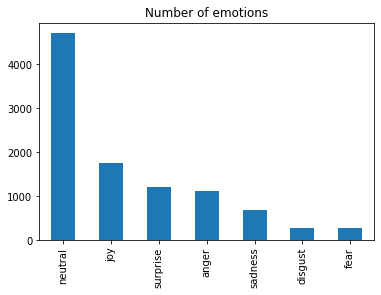

In [272]:
train_df['Emotion'].value_counts().sort_values(ascending=False).plot(kind='bar', 
                                                                title='Number of emotions')



In [273]:
# label encoding (0 to 6)
# anger = 0
# disgust = 1
# fear = 2
# joy = 3
# neutral = 4
# sadness = 5
# surprise = 6

train_df[['Emotion']] = train_df[['Emotion']].apply(LabelEncoder().fit_transform) 
test_df[['Emotion']] = test_df[['Emotion']].apply(LabelEncoder().fit_transform) 


In [274]:
df2 = train_df.drop(train_df.columns[[0,2,4,5,6,7,8,9,10]],axis=1)
df3 = test_df.drop(train_df.columns[[0,2,4,5,6,7,8,9,10]],axis=1)

df2

,Utterance,Emotion
0,also I was the point person on my companys tr...,4
1,You mustve had your hands full.,4
2,That I did. That I did.,4
3,So lets talk a little bit about your duties.,4
4,My duties? All right.,6
...,...,...
9984,You or me?,4
9985,"I got it. Uh, Joey, women don't have Adam's ap...",4
9986,"You guys are messing with me, right?",6
9987,Yeah.,4


In [275]:
df2.Emotion.value_counts()

4    4710
3    1743
6    1205
0    1109
5     683
1     271
2     268
Name: Emotion, dtype: int64

# Dataloader

 create train,valid and test datasets

In [276]:
from sklearn.model_selection import train_test_split
from collections import Counter

X_train, X_valid, Y_train, Y_valid= train_test_split(df2['Utterance'].tolist(),\
                                                      df2['Emotion'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = df2['Emotion'].tolist(),\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(Y_train)))


print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(Y_valid)))

print('Test data len:'+str(len(df3['Utterance'].tolist())))
print('Class distribution'+ str(Counter(df3['Emotion'].tolist())))


train_dat =list(zip(Y_train,X_train))
valid_dat =list(zip(Y_valid,X_valid))
test_dat=list(zip(df3['Emotion'].tolist(),df3['Utterance'].tolist()))


Train data len:7991
Class distributionCounter({4: 3768, 3: 1394, 6: 964, 0: 887, 5: 546, 1: 217, 2: 215})
Valid data len:1998
Class distributionCounter({4: 942, 3: 349, 6: 241, 0: 222, 5: 137, 1: 54, 2: 53})
Test data len:2610
Class distributionCounter({4: 1256, 3: 402, 0: 345, 6: 281, 5: 208, 1: 68, 2: 50})


In [277]:
import torch
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

create vocabulary on train data

In [278]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = train_dat
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

define text and label preprocessing pipelines

In [279]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) 

In [251]:
text_pipeline('here is an example')  # example

[49, 16, 122, 3365]

In [252]:
label_pipeline('1')  # example

1

In [280]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

# Text Classification Model

In [314]:
from torch import nn
import torch.nn.functional as F

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc1 = nn.Linear(embed_dim,64)
        self.fc2 = nn.Linear(64,16)
        self.fc3 = nn.Linear(16, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc1.weight.data.uniform_(-initrange, initrange)
        self.fc1.bias.data.zero_()
        self.fc2.weight.data.uniform_(-initrange, initrange)
        self.fc2.bias.data.zero_()
        self.fc3.weight.data.uniform_(-initrange, initrange)
        self.fc3.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        x = F.relu(self.fc1(embedded))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

create an object of text classification class

In [315]:
train_iter1 = train_dat
num_class = 7
vocab_size = len(vocab)
emsize = 128
model = TextClassificationModel(vocab_size, emsize, num_class)#.to(device)

define train and evaluation loop

In [322]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 50
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

create dataloaders for text,train and validation data iterators and then train model

In [324]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 25 # epoch
LR = 0.001  # learning rate
BATCH_SIZE = 32 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_iter2 = train_dat
test_iter2 =test_dat 
valid_iter2= valid_dat




train_dataloader = DataLoader(train_iter2, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_iter2, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_iter2, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |    50/  250 batches | accuracy    0.517
| epoch   1 |   100/  250 batches | accuracy    0.496
| epoch   1 |   150/  250 batches | accuracy    0.515
| epoch   1 |   200/  250 batches | accuracy    0.499
-----------------------------------------------------------
| end of epoch   1 | time:  0.73s | valid accuracy    0.506 
-----------------------------------------------------------
| epoch   2 |    50/  250 batches | accuracy    0.499
| epoch   2 |   100/  250 batches | accuracy    0.501
| epoch   2 |   150/  250 batches | accuracy    0.526
| epoch   2 |   200/  250 batches | accuracy    0.495
-----------------------------------------------------------
| end of epoch   2 | time:  0.71s | valid accuracy    0.508 
-----------------------------------------------------------
| epoch   3 |    50/  250 batches | accuracy    0.507
| epoch   3 |   100/  250 batches | accuracy    0.521
| epoch   3 |   150/  250 batches | accuracy    0.512
| epoch   3 |   200/  250 batches | accuracy

In [325]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.521


test model on text

In [327]:
emotion_label = {6: "Surprise",
                   5: "Sadness",
                   4: "Neutral",
                   3: "Joy",
                   2:"Fear",
                   1: "Disgust",
                   0: "Anger"
                  }



def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() 
ex_text_str = "And if, and if you dont understand how important this is to me, well then, perhaps we shouldnt get married at all!"
model = model.to("cpu")

print("This is %s" %emotion_label[predict(ex_text_str, text_pipeline)])

This is Neutral


In [289]:
print(X_train[23])
print(Y_train[23])

And if, and if you dont understand how important this is to me, well then, perhaps we shouldnt get married at all!
0
